# EffTox - General Usage

This IPython notebook illustrates the use of the `EffTox` class in the `clintrials` package.

The design was first published:

- Thall & Cook in 2004, _Dose-Finding Based on Efficacy-Toxicity Trade-Offs_, Biometrics vol 60, issue 3.

Follow-up publications were:

- Thall, Cook & Estey, 2006, _Adaptive dose selection using efficacy-toxicity trade-offs: illustrations and practical considerations_ 
- Cook, 2006, _Efficacy-Toxicity trade-offs based on L-p norms Technical Report UTMDABTR-003-06 Bivariate binary model_.

In [1]:
import numpy as np
from scipy.stats import norm

from clintrials.dosefinding.efftox import EffTox, LpNormCurve, scale_doses

In [2]:
real_doses = [7.5, 15, 30, 45]
dose_indices = range(1, len(real_doses)+1)
trial_size = 30
cohort_size = 3
first_dose = 3

In [3]:
prior_tox_probs = (0.025, 0.05, 0.1, 0.25)
prior_eff_probs = (0.2, 0.3, 0.5, 0.6)
tox_cutoff = 0.40
eff_cutoff = 0.45
tox_certainty = 0.05
eff_certainty = 0.05  # The original Matchpoint implementation. Later changed to 0.03

The priors below correspond to ESS=1.3 and were calculated using v4.0.12 of the EffTox, available at https://biostatistics.mdanderson.org/softwaredownload/SingleSoftware.aspx?Software_Id=2

Ideally, clintrials should include the algorithm to calculate priors but I have not written it yet. KB

In [4]:
mu_t_mean, mu_t_sd = -5.4317, 2.7643
beta_t_mean, beta_t_sd = 3.1761, 2.7703
mu_e_mean, mu_e_sd = -0.8442, 1.9786
beta_e_1_mean, beta_e_1_sd = 1.9857, 1.9820
beta_e_2_mean, beta_e_2_sd = 0, 0.2
psi_mean, psi_sd = 0, 1
efftox_priors = [
    norm(loc=mu_t_mean, scale=mu_t_sd),
    norm(loc=beta_t_mean, scale=beta_t_sd),
    norm(loc=mu_e_mean, scale=mu_e_sd),
    norm(loc=beta_e_1_mean, scale=beta_e_1_sd),
    norm(loc=beta_e_2_mean, scale=beta_e_2_sd),
    norm(loc=psi_mean, scale=psi_sd),
    ]

The metric is the object that calculates the utility of a $(\pi_E, \pi_T)$ pair. The hinge points are the three elicited points of equal utility used to identify the curve, as explained in Thall & Cook, 2004.

In [5]:
hinge_points = [(0.4, 0), (1, 0.7), (0.5, 0.4)]
metric = LpNormCurve(hinge_points[0][0], hinge_points[1][1], hinge_points[2][0], hinge_points[2][1])

Finally, the EffTox instance is created:

In [6]:
et = EffTox(real_doses, efftox_priors, tox_cutoff, eff_cutoff, tox_certainty, eff_certainty, metric, trial_size,
            first_dose)

The EffTox object does all the work. For instance, consider the scenario where three patients are given dose-level 3:

- The first patient has both toxicity and efficacy. This is represented by the tuple (3, 1, 1)
- The second has efficacy without toxicity. This is represented by the tuple (3, 0, 1)
- The third has toxicity without efficacy. This is represented by the tuple (3, 1, 0)

Putting that information into a list:

In [7]:
cases = [(3, 1, 1), (3, 0, 1), (3, 1, 0)]

and updating the model with 1,000,000 points in the posterior integral:

In [8]:
np.random.seed(123)
et.reset()
next_dose = et.update(cases, n=10**6)
next_dose

3

We can take a look at the posterior beliefs on the efficacy probabilities at each dose:

In [9]:
et.prob_eff

(0.22909895137983396,
 0.35053241690829945,
 0.61568794872530819,
 0.74353588349370703)

and the toxicity probabilities:

In [10]:
et.prob_tox

(0.058092319375473135,
 0.11712850384219034,
 0.50566447565218831,
 0.784448543115147)

and the probabilities that each dose satisfies the criteria for admissability, i.e. is _probably efficable_ and _probably tolerable_:

In [13]:
et.prob_acc_eff

(0.21059875566520109,
 0.32883237208689137,
 0.73876174765358893,
 0.88580738404486803)

In [14]:
 et.prob_acc_tox

(0.94719263840884738,
 0.91318557813996248,
 0.35877428485481755,
 0.083172938628579329)

We see that all doses admissable.

For confirmation:

In [15]:
et.admissable_set()

[1, 2, 3, 4]

Of course, there are only three observations in the trial. Not many at all. Let's add some data for twelve more patients.

The EffTox class remembers the cases it has already seen and adds to those when you call `update`.

In [16]:
cases = [
    (3, 0, 0), (3, 0, 1), (3, 1, 0),
    (4, 1, 1), (4, 1, 1), (4, 0, 0),
    (3, 1, 0), (3, 1, 1), (3, 0, 1),
    (2, 0, 0), (2, 0, 0), (2, 0, 1),
    ]

In [17]:
et.update(cases, n=10**6)

3

Confirmation that dose-level 3 is the dose with highest utility:

In [18]:
et.utility

array([-0.34514655, -0.14333504,  0.04748648, -0.22267541])

The trial has more data in it now:

In [19]:
et.size()

15

Notice that the sample size is 15 and not 12? This is because calls to the `update` method are cumulative, i.e. the EffTox class also includes the original three outcomes. To make an instance of EffTox forget what it knows and start afresh, use `et.reset()`

We have now explored more doses:

In [20]:
et.tabulate()

,Dose,N,Efficacies,Toxicities,EffRate,ToxRate,P(Eff),P(Tox),P(AccEff),Admissible,Utility
0,1,0,0,0,NaN,NaN,0.193076,0.021982,0.988234,True,-0.345147
1,2,3,1,0,0.333333,0.000000,0.316629,0.077165,0.983566,True,-0.143335
2,3,9,5,5,0.555556,0.555556,0.573047,0.454695,0.326676,True,0.047486
3,4,3,2,2,0.666667,0.666667,0.716609,0.795794,0.031800,False,-0.222675


so we have a bit more faith in posterior beliefs:

In [18]:
et.prob_eff

(0.17741533076916405,
 0.2975076349271551,
 0.55450648405387493,
 0.70230005873667289)

If ggplot is available, we can look at estimates of the posterior densities of utility, efficacy probability and toxicity probability.

For instance:

In [19]:
import ggplot

In [20]:
%matplotlib inline

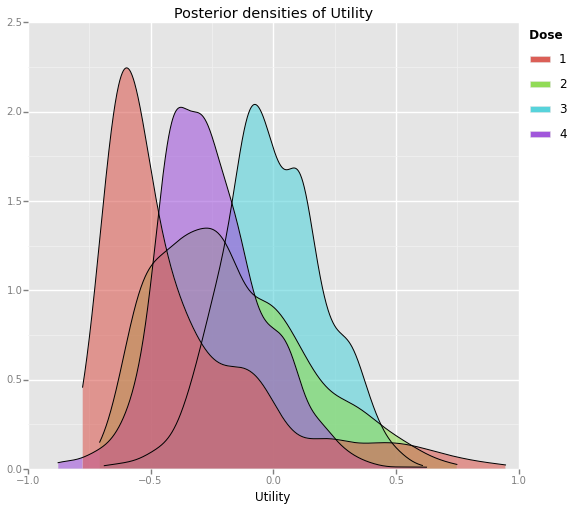

<ggplot: (282876473)>

In [21]:
et.plot_posterior_utility_density()

We see that dose-level 3 has the highest utility, quite comfortably.

Posterior mean estimates of the parameter vector $\theta$ are available:

In [22]:
et.posterior_params(n=10**6)

[(-2.1198391463454924,
  4.4371729478088291,
  -0.51811568490241766,
  1.7487101532635487,
  0.0024753454343415444,
  -0.9697855135784671)]

Kristian Brock, Sep 2015.